In [1]:
import pandas as pd
import numpy as np
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split as tts
%matplotlib inline

In [2]:
df = pd.read_csv(r'../Python3Code/intermediate_datafiles/chapter2_result.csv')

cols = ['acc_phone_x', 'acc_phone_y', 'acc_phone_z',
       'acc_watch_x', 'acc_watch_y', 'acc_watch_z', 'gyr_phone_x',
       'gyr_phone_y', 'gyr_phone_z', 'gyr_watch_x', 'gyr_watch_y',
       'gyr_watch_z', 'hr_watch_rate',
       'light_phone_lux', 'mag_phone_x', 'mag_phone_y', 'mag_phone_z', 
        'mag_watch_x', 'mag_watch_y', 'mag_watch_z', 'press_phone_pressure']

df = df[cols]

In [3]:
df['hr_watch_rate'].isnull().sum() / len(df)

0.7640869401344306

In [ ]:
for column in df.columns:
    df.loc[(df[column] > (df[column].mean() + 4*df[column].std())), column] = np.nan
    df.loc[(df[column] < (df[column].mean() - 4*df[column].std())), column] = np.nan

# BASELINE

In [4]:
heartrate = df[df['hr_watch_rate'].notnull()]['hr_watch_rate']
baseline_pred = np.repeat(heartrate.mean(), len(heartrate))
print('Baseline RMSE:', round(np.sqrt(mse(heartrate, baseline_pred)), 3))

Baseline RMSE: 35.23


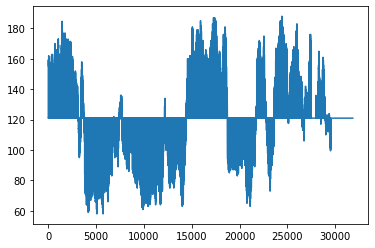

In [5]:
plt.plot(df['hr_watch_rate'].fillna(heartrate.mean()))

# INTERPOLATION

In [ ]:
plt.plot(df['hr_watch_rate'].interpolate())

# MODEL

In [6]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= False, seed = 1001):
    # Divide in training/validation and test data
    train_df = df[df['hr_watch_rate'].notnull()]
    test_df = df[df['hr_watch_rate'].isnull()]
        
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_split_df = pd.DataFrame()
    feature_importance_gain_df = pd.DataFrame()
    fold_prediction = test_df.copy()

    feats = [f for f in train_df.columns if f not in ['hr_watch_rate']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['hr_watch_rate'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['hr_watch_rate'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['hr_watch_rate'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMRegressor(
            metric = 'rmse',
            nthread=-1,
            n_estimators=100000,
            learning_rate=0.15,
            num_leaves=10,
            colsample_bytree=.6,
            subsample=0.6,
            max_depth=3,
            reg_alpha=.7,
            reg_lambda=.9,
            min_child_samples = 1200,
            min_child_weight = 60,
            min_data_per_group = 1200,
            min_data_in_bin = 300,
            silent=-1,
            verbose=-1)

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'rmse', verbose= 100, early_stopping_rounds= 200)
        
        oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)
        
        test_pred =  clf.predict(test_df[feats], num_iteration=clf.best_iteration_)
        sub_preds += test_pred / folds.n_splits
        
        fold_prediction.loc[:, str(seed) + '_fold_' + str(n_fold)] = test_pred

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.booster_.feature_importance(importance_type = 'split')
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_split_df = pd.concat([feature_importance_split_df, fold_importance_df], axis=0)
        
        fold_importance_df2 = pd.DataFrame()
        fold_importance_df2["feature"] = feats
        fold_importance_df2["importance"] = clf.booster_.feature_importance(importance_type = 'gain')
        fold_importance_df2["fold"] = n_fold + 1
        feature_importance_gain_df = pd.concat([feature_importance_gain_df, fold_importance_df2], axis=0)        
        
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, np.sqrt(mse(valid_y, oof_preds[valid_idx]))))
        print()
        del clf, train_x, train_y, valid_x, valid_y

    print('Full RMSE score %.6f' % np.sqrt(mse(train_df['hr_watch_rate'], oof_preds)))
 
    display_importances(feature_importance_split_df)
    display_importances(feature_importance_gain_df)
    return feature_importance_split_df, feature_importance_gain_df, fold_prediction

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", 
                                                                                                   ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

Starting LightGBM. Train shape: (7511, 21), test shape: (24327, 21)
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 20.9133	valid_1's rmse: 20.8261
[200]	training's rmse: 19.342	valid_1's rmse: 19.4693
[300]	training's rmse: 18.4775	valid_1's rmse: 18.7861
[400]	training's rmse: 17.905	valid_1's rmse: 18.3531
[500]	training's rmse: 17.4594	valid_1's rmse: 18.0382
[600]	training's rmse: 17.0957	valid_1's rmse: 17.8059
[700]	training's rmse: 16.7812	valid_1's rmse: 17.5883
[800]	training's rmse: 16.5069	valid_1's rmse: 17.4016
[900]	training's rmse: 16.263	valid_1's rmse: 17.208
[1000]	training's rmse: 16.0379	valid_1's rmse: 17.0848
[1100]	training's rmse: 15.8346	valid_1's rmse: 16.9697
[1200]	training's rmse: 15.6438	valid_1's rmse: 16.8606
[1300]	training's rmse: 15.4711	valid_1's rmse: 16.7818
[1400]	training's rmse: 15.32	valid_1's rmse: 16.6911
[1500]	training's rmse: 15.1676	valid_1's rmse: 16.5885
[1600]	training's rmse: 15.0307	valid_1's rms

[3700]	training's rmse: 13.3534	valid_1's rmse: 15.8873
[3800]	training's rmse: 13.304	valid_1's rmse: 15.8613
[3900]	training's rmse: 13.2599	valid_1's rmse: 15.8356
[4000]	training's rmse: 13.2105	valid_1's rmse: 15.8194
[4100]	training's rmse: 13.1702	valid_1's rmse: 15.8107
[4200]	training's rmse: 13.1288	valid_1's rmse: 15.791
[4300]	training's rmse: 13.0851	valid_1's rmse: 15.7801
[4400]	training's rmse: 13.0383	valid_1's rmse: 15.7621
[4500]	training's rmse: 12.9938	valid_1's rmse: 15.7389
[4600]	training's rmse: 12.9484	valid_1's rmse: 15.7181
[4700]	training's rmse: 12.9107	valid_1's rmse: 15.702
[4800]	training's rmse: 12.8711	valid_1's rmse: 15.6872
[4900]	training's rmse: 12.8327	valid_1's rmse: 15.6683
[5000]	training's rmse: 12.7949	valid_1's rmse: 15.6538
[5100]	training's rmse: 12.7578	valid_1's rmse: 15.6305
[5200]	training's rmse: 12.7222	valid_1's rmse: 15.6118
[5300]	training's rmse: 12.6885	valid_1's rmse: 15.5894
[5400]	training's rmse: 12.6553	valid_1's rmse: 15.

[6300]	training's rmse: 12.4452	valid_1's rmse: 14.782
[6400]	training's rmse: 12.4115	valid_1's rmse: 14.7702
[6500]	training's rmse: 12.3802	valid_1's rmse: 14.7584
[6600]	training's rmse: 12.3486	valid_1's rmse: 14.7391
[6700]	training's rmse: 12.3107	valid_1's rmse: 14.7209
[6800]	training's rmse: 12.2755	valid_1's rmse: 14.7068
[6900]	training's rmse: 12.2433	valid_1's rmse: 14.6874
[7000]	training's rmse: 12.21	valid_1's rmse: 14.6722
[7100]	training's rmse: 12.1808	valid_1's rmse: 14.6507
[7200]	training's rmse: 12.15	valid_1's rmse: 14.6483
[7300]	training's rmse: 12.1224	valid_1's rmse: 14.6371
[7400]	training's rmse: 12.0887	valid_1's rmse: 14.6176
[7500]	training's rmse: 12.0603	valid_1's rmse: 14.6084
[7600]	training's rmse: 12.0327	valid_1's rmse: 14.606
[7700]	training's rmse: 12.0039	valid_1's rmse: 14.5916
[7800]	training's rmse: 11.9711	valid_1's rmse: 14.5764
[7900]	training's rmse: 11.9448	valid_1's rmse: 14.5683
[8000]	training's rmse: 11.9177	valid_1's rmse: 14.566

[8400]	training's rmse: 11.4946	valid_1's rmse: 15.5337
[8500]	training's rmse: 11.4749	valid_1's rmse: 15.5265
[8600]	training's rmse: 11.4494	valid_1's rmse: 15.5144
[8700]	training's rmse: 11.4282	valid_1's rmse: 15.5082
[8800]	training's rmse: 11.4117	valid_1's rmse: 15.5009
[8900]	training's rmse: 11.3903	valid_1's rmse: 15.4948
[9000]	training's rmse: 11.366	valid_1's rmse: 15.4795
[9100]	training's rmse: 11.3441	valid_1's rmse: 15.4704
[9200]	training's rmse: 11.323	valid_1's rmse: 15.4578
[9300]	training's rmse: 11.3002	valid_1's rmse: 15.4444
[9400]	training's rmse: 11.2784	valid_1's rmse: 15.4428
[9500]	training's rmse: 11.2584	valid_1's rmse: 15.4434
[9600]	training's rmse: 11.2403	valid_1's rmse: 15.4314
[9700]	training's rmse: 11.2194	valid_1's rmse: 15.4294
[9800]	training's rmse: 11.1989	valid_1's rmse: 15.4177
[9900]	training's rmse: 11.1792	valid_1's rmse: 15.4141
[10000]	training's rmse: 11.1616	valid_1's rmse: 15.4056
[10100]	training's rmse: 11.1397	valid_1's rmse: 

[9300]	training's rmse: 11.4782	valid_1's rmse: 14.9133
[9400]	training's rmse: 11.454	valid_1's rmse: 14.9086
[9500]	training's rmse: 11.4324	valid_1's rmse: 14.9014
[9600]	training's rmse: 11.41	valid_1's rmse: 14.8984
[9700]	training's rmse: 11.3847	valid_1's rmse: 14.899
[9800]	training's rmse: 11.3619	valid_1's rmse: 14.8944
[9900]	training's rmse: 11.3379	valid_1's rmse: 14.8891
[10000]	training's rmse: 11.3165	valid_1's rmse: 14.8866
[10100]	training's rmse: 11.2967	valid_1's rmse: 14.8788
[10200]	training's rmse: 11.2746	valid_1's rmse: 14.8755
[10300]	training's rmse: 11.2527	valid_1's rmse: 14.8755
[10400]	training's rmse: 11.2304	valid_1's rmse: 14.8769
Early stopping, best iteration is:
[10268]	training's rmse: 11.2598	valid_1's rmse: 14.8733
Fold  5 RMSE : 14.873324

Full RMSE score 14.822333


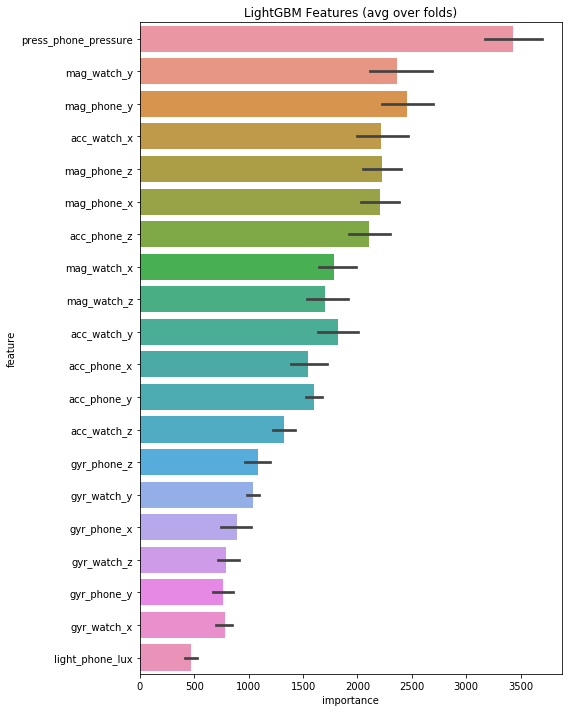

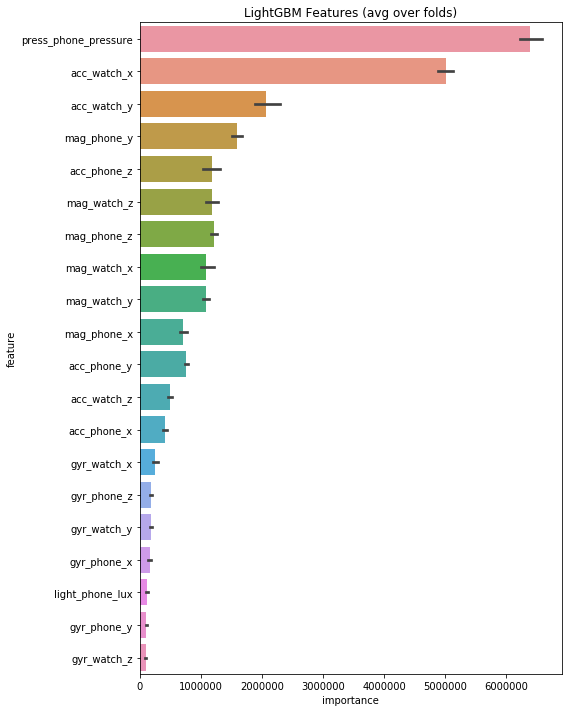

In [7]:
split, gain, pred = kfold_lightgbm(df, 5)

In [8]:
df.loc[pred.index, 'hr_watch_rate'] = pred[['1001_fold_0', '1001_fold_1',
                                        '1001_fold_2', '1001_fold_3',
                                        '1001_fold_4']].mean(axis=1)

In [ ]:
plt.plot(df['hr_watch_rate'])

In [ ]:
df.to_csv('Crowdsignal_imputed_hr.csv', index=False)